# PFRL Quickstart Guide

This is a quickstart guide for users who just want to try PFRL for the first time.

If you have not yet installed PFRL, run the command below to install it:
```
pip install pfrl
```

If you have already installed PFRL, let's begin!

First, you need to import necessary modules. The module name of PFRL is `pfrl`. Let's import `torch`, `gym`, and `numpy` as well since they are used later.

In [1]:
import pfrl
import torch
import torch.nn
import gym
import numpy

PFRL can be used for any problems if they are modeled as "environments". [OpenAI Gym](https://github.com/openai/gym) provides various kinds of benchmark environments and defines the common interface among them. PFRL uses a subset of the interface. Specifically, an environment must define its observation space and action space and have at least two methods: `reset` and `step`.

- `env.reset` will reset the environment to the initial state and return the initial observation.
- `env.step` will execute a given action, move to the next state and return four values:
  - a next observation
  - a scalar reward
  - a boolean value indicating whether the current state is terminal or not
  - additional information
- `env.render` will render the current state. (optional)

Let's try `CartPole-v0`, which is a classic control problem. You can see below that its observation space consists of four real numbers while its action space consists of two discrete actions.

In [2]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
print('initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('action:', action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

# Uncomment to open a GUI window rendering the current state of the environment
# env.render()

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
initial observation: [ 0.04508181  0.00276376 -0.04563582  0.00414576]
action: 1
next observation: [ 0.04513709  0.19850947 -0.04555291 -0.3025794 ]
reward: 1.0
done: False
info: {}


/home/ugproj/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/ugproj/anaconda3/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/ugproj/anaconda3/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/ugproj/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated

Now you have defined your environment. Next, you need to define an agent, which will learn through interactions with the environment.

PFRL provides various agents, each of which implements a deep reinforcement learning algorithm.

Let's try using the DoubleDQN algorithm (https://arxiv.org/abs/1509.06461), which is implemented by `pfrl.agents.DoubleDQN`. This algorithm trains a Q-function that receives an observation and returns an expected future return for each action the agent can take. In PFRL, you can define your Q-function as `torch.nn.Module` as below. Note that the outputs are wrapped by `pfrl.action_value.DiscreteActionValue`. By wrapping the outputs of Q-functions, PFRL can support not only discrete-action Q-functions like this but also continuous-action Q-functions (via [Normalized Advantage Functions](https://arxiv.org/abs/1603.00748)) in the same way.

In [3]:
import torch.nn.functional as F

class QFunction(torch.nn.Module):

    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, 128)
        self.fc2 = torch.nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return pfrl.action_value.DiscreteActionValue(x)

obs_size = env.observation_space.low.size
n_actions = env.action_space.n
q_func = QFunction(obs_size, n_actions)

It is also possible to define the same model using `torch.nn.Sequential`. `pfrl.q_functions.DiscreteActionValueHead` is just a `torch.nn.Module` that packs its input to `pfrl.action_value.DiscreteActionValue`.

In [4]:
# q_func2 = torch.nn.Sequential(
#     torch.nn.Linear(obs_size, 50),
#     torch.nn.ReLU(),
#     torch.nn.Linear(50, 50),
#     torch.nn.ReLU(),
#     torch.nn.Linear(50, n_actions),
#     pfrl.q_functions.DiscreteActionValueHead(),
# )

As usual in PyTorch, `torch.optim.Optimizer` is used to optimize a model.

In [5]:
# Use Adam to optimize q_func. eps=1e-2 is for stability.
# optimizer = torch.optim.Adam(q_func.parameters(), eps=1e-2)
optimizer = torch.optim.Adam(q_func.parameters(), lr=2e-3)

To create a DoubleDQN agent with these Q-function and optimizer, you need to specify a bit more parameters and configurations.

In [6]:
# Set the discount factor that discounts future rewards.
gamma = 0.98

# Use epsilon-greedy for exploration
explorer = pfrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.01, random_action_func=env.action_space.sample)

# DQN uses Experience Replay.
# Specify a replay buffer and its capacity.
replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=10 ** 4)

# Since observations from CartPole-v0 is numpy.float64 while
# As PyTorch only accepts numpy.float32 by default, specify
# a converter as a feature extractor function phi.
phi = lambda x: x.astype(numpy.float32, copy=False)

# Set the device id to use GPU. To use CPU only, set it to -1.
gpu = 0

# Now create an agent that will interact with the environment.
agent = pfrl.agents.DoubleDQN(
    q_func,
    optimizer,
    replay_buffer,
    gamma,
    explorer,
    replay_start_size=500,
    update_interval=1,
    target_update_interval=10,
    phi=phi,
    gpu=gpu,
)

Now you have an agent and an environment. It's time to start reinforcement learning!

During training, two methods of `agent` must be called: `agent.act` and `agent.observe`. `agent.act(obs)` takes the current observation as input and returns an exploratory action. Once the returned action is processed in the env, `agent.observe(obs, reward, done, reset)` then observes the consequences:
- `obs`: next observation.
- `reward`: an immediate reward.
- `done`: a boolean value set to True if it reached a terminal state.
- `reset`: a boolean value set to True if an episode is interrupted at a non-terminal state, typically by a time limit.

Optionally, you can get training statistics of the agent via `agent.get_statistics`.

In [7]:
n_episodes = 500
max_episode_len = 200
return_list = []

for i in range(1, n_episodes + 1):
    obs = env.reset()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
        reset = t == max_episode_len
        agent.observe(obs, reward, done, reset)
        if done or reset:
            break
    if i % 10 == 0:
        print('episode:', i, 'R:', R)
    if i % 50 == 0:
        print('statistics:', agent.get_statistics())
    return_list.append(R)
print('Finished.')

episode: 10 R: 8.0
episode: 20 R: 10.0
episode: 30 R: 10.0
episode: 40 R: 10.0
episode: 50 R: 9.0
statistics: [('average_q', nan), ('average_loss', nan), ('cumulative_steps', 471), ('n_updates', 0), ('rlen', 471)]
episode: 60 R: 10.0
episode: 70 R: 9.0
episode: 80 R: 8.0
episode: 90 R: 9.0
episode: 100 R: 8.0
statistics: [('average_q', 414.15833), ('average_loss', 84.96787645339965), ('cumulative_steps', 936), ('n_updates', 437), ('rlen', 936)]
episode: 110 R: 9.0
episode: 120 R: 10.0
episode: 130 R: 10.0
episode: 140 R: 10.0
episode: 150 R: 9.0
statistics: [('average_q', 2034.5962), ('average_loss', 580.7138833618164), ('cumulative_steps', 1406), ('n_updates', 907), ('rlen', 1406)]
episode: 160 R: 8.0
episode: 170 R: 10.0
episode: 180 R: 10.0
episode: 190 R: 9.0
episode: 200 R: 8.0
statistics: [('average_q', 4850.416), ('average_loss', 1376.8552868652343), ('cumulative_steps', 1884), ('n_updates', 1385), ('rlen', 1884)]
episode: 210 R: 11.0
episode: 220 R: 10.0
episode: 230 R: 9.0
epi

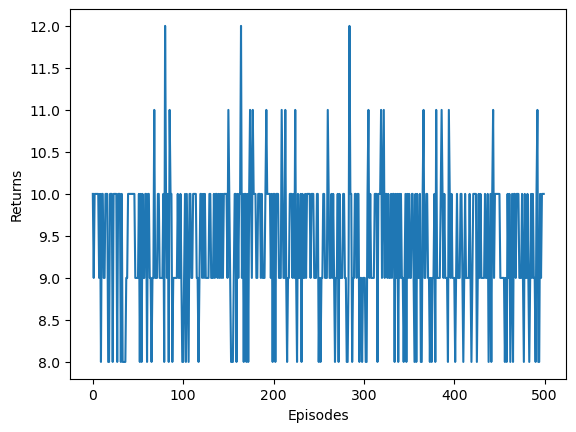

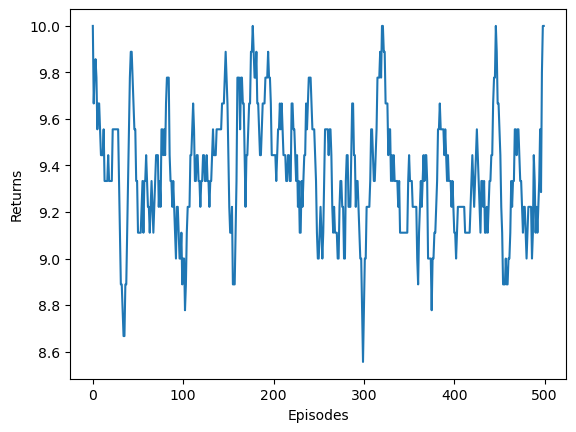

In [8]:
import matplotlib.pyplot as plt
import rl_utils

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.show()

Now you finished training the DoubleDQN agent for 300 episodes. How good is the agent now? You can evaluate it by using `with agent.eval_mode()`. Exploration such as epsilon-greedy is not used anymore.

In [ ]:
with agent.eval_mode():
    for i in range(10):
        obs = env.reset()
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            # env.render()
            action = agent.act(obs)
            obs, r, done, _ = env.step(action)
            R += r
            t += 1
            reset = t == 200
            agent.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)

For your information, `CartPole-v0`'s maximum achievable return is 200. If the agent could not achieve 200, it was unlucky! You can train the agent longer by running the training loop again.

If the results are good enough, the only remaining task is to save the agent so that you can reuse it. What you need to do is to simply call `agent.save` to save the agent, then `agent.load` to load the saved agent.

In [ ]:
# Save an agent to the 'agent' directory
agent.save('agent')

# Uncomment to load an agent from the 'agent' directory
# agent.load('agent')

RL completed!

But writing code like this every time you use RL might be tedious. So, PFRL has utility functions that do these things.

In [ ]:
# Set up the logger to print info messages for understandability.
import logging
import sys
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

pfrl.experiments.train_agent_with_evaluation(
    agent,
    env,
    steps=2000,           # Train the agent for 2000 steps
    eval_n_steps=None,       # We evaluate for episodes, not time
    eval_n_episodes=10,       # 10 episodes are sampled for each evaluation
    train_max_episode_len=200,  # Maximum length of each episode
    eval_interval=1000,   # Evaluate the agent after every 1000 steps
    outdir='result',      # Save everything to 'result' directory
)

That's all of the PFRL quickstart guide. To know more about PFRL, please look into the `examples` directory and read and run the examples. Thank you!